In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import jax
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
%load_ext cython

In [ ]:
movies = pd.read_csv('./ml-1m/movies.dat', sep = '::', header = None, names = ["MovieID", "Title", "Genres"], engine='python',encoding='latin-1')
ratings = pd.read_csv('./ml-1m/ratings.dat',sep='::',header=None,engine='python',names=["UserID", "MovieID", "Rating", "Timestamp"])
users = pd.read_csv('./ml-1m/users.dat',sep='::',header=None,engine='python',names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [ ]:
display(movies.head())
display(ratings.head())
display(users.head())

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
movie_ratings = movies.set_index("MovieID").join(ratings.set_index("MovieID"), on = 'MovieID').reset_index()

In [ ]:
movie_ratings.isnull().any()

MovieID      False
Title        False
Genres       False
UserID        True
Rating        True
Timestamp     True
dtype: bool

In [ ]:
movie_train, movie_test = train_test_split(movie_ratings, test_size = 0.1,random_state = 4212)
movie_train.shape

(900347, 6)

In [ ]:
movie_train

,MovieID,Title,Genres,UserID,Rating,Timestamp
435605,1538,"Second Jungle Book: Mowgli & Baloo, The (1997)",Adventure|Children's,1826.0,3.0,974696674.0
448860,1590,Event Horizon (1997),Action|Mystery|Sci-Fi|Thriller,2239.0,5.0,986875471.0
515754,1923,There's Something About Mary (1998),Comedy,1613.0,4.0,974731947.0
867573,3256,Patriot Games (1992),Action|Thriller,5140.0,4.0,962059309.0
516001,1923,There's Something About Mary (1998),Comedy,2737.0,4.0,973227603.0
...,...,...,...,...,...,...
643310,2376,"View to a Kill, A (1985)",Action,2503.0,4.0,974085788.0
993361,3897,Almost Famous (2000),Comedy|Drama,2700.0,5.0,973304646.0
710541,2642,Superman III (1983),Action|Adventure|Sci-Fi,4592.0,2.0,964300717.0
942857,3623,Mission: Impossible 2 (2000),Action|Thriller,5880.0,5.0,959797041.0


In [ ]:
# creating matrix of (movies X users) containing their ratings

movie_ind = {} # movieID as key, index as val
ind_movie = {} # index as key, movieID as val
for ind, row in movies.iterrows():
    movie_ind[row.MovieID] = ind
    ind_movie[ind] = row.MovieID

mat_template = [[0 for _ in range(len(users))] for _ in range(len(movies))]
mat = np.asarray(mat_template)
for ind, row in movie_train.iterrows():
    if row.UserID>0:
        mat[int(movie_ind[row.MovieID])-1][int(row.UserID)-1] = row.Rating

test_mat = np.asarray(mat_template)
for ind, row in movie_test.iterrows():
    if row.UserID>0:
        test_mat[int(movie_ind[row.MovieID])-1][int(row.UserID)-1] = row.Rating


In [ ]:
%%cython
cimport numpy as np
import numpy as np
import jax
import jax.numpy as jnp
from tqdm import tqdm

class SVD():
    def __init__(self, k = 20, n_epochs = 20, biased = True, lr = 0.005, reg = 0.02, random_state = 4212):
        
        """
        k        : Latent factor size
        n_epochs : Number of iterations for SGD
        biased   : If True, Funk SVD. If False, PMF.
        lr       : Learning rate for each parameter. If not set manually, use this as default
        reg      : Regularization for each parameter. If not set manually, use this as default
        """
        self.k = k
        self.n_epochs = n_epochs
        self.biased = biased
        self.lr = lr
        self.reg = reg
        self.random_state = random_state
        self.loss = []
        
    def fit(self, trainset):
        self.sgd(trainset)
        return self
    
    def sgd(self,trainset):
        """
        Run SGD using the following pseudocode
        """
        np.random.seed(self.random_state)
        

        cdef np.ndarray[np.double_t] bu

        cdef np.ndarray[np.double_t] bi

        cdef np.ndarray[np.double_t, ndim=2] pu

        cdef np.ndarray[np.double_t, ndim=2] qi
        
        cdef int u,i,j
        cdef double r, err, pred, buu, bii
        
        
        n_users, n_items = trainset.shape
        bu = np.zeros(n_users, np.double)
        bi = np.zeros(n_items, np.double)
        pu = np.random.normal(0,1,(n_users,self.k))
        qi = np.random.normal(0,1,(n_items, self.k))
        
        
        all_ratings = self.get_all_ratings(trainset) 
        global_mean = self.get_mean(all_ratings)
        self.global_mean = global_mean
        ## if biased is false, algorithm is probabilistic matrix factorization
        if not self.biased:
            self.global_mean = 0
            
        for epoch in range(self.n_epochs):
            err_lst = []
            print("Current epoch: ", epoch+1)
            for u, i, r in tqdm(all_ratings):

                ## Compute Error
                ## Note: Using Jax is much slower to do dot product
                dot = 0
                for j in range(self.k):
                    dot += qi[i,j] * pu[u,j]
                buu = bu[u]
                bii = bi[i]
                err = r - (self.global_mean + buu + bii + dot)
                
                err_lst.append(err)
                ## Update Bias
                """
                b_u = b_u + lr(err - reg*b_u)
                b_i = b_i + lr(err - reg*b_i)
                """
                if self.biased:
                    bu[u] = buu + self.lr * (err - self.reg*buu)
                    bi[i] = bii + self.lr * (err - self.reg*bii)

                ## Update latent factors
                """
                p_u = p_u + lr(err*q_i - reg*p_u)
                q_i = q_i + lr(err*p_u - reg*p_u)
                *note: since p_u will be updated prior to updating q_i, we need to store value of p_u
                """
                for j in range(self.k):
                    pu_j = pu[u,j]
                    qi_j = qi[i,j]
                    pu[u,j] = pu_j + self.lr * (err*qi_j - self.reg*pu_j)
                    qi[i,j] = qi_j + self.lr * (err*pu_j - self.reg*qi_j)
            self.loss.append((np.mean(err_lst))**2)
        
        ## store all the biases and latent factors
        self.bu = bu
        self.bi = bi
        self.pu = pu
        self.qi = qi        
            
    def get_all_ratings(self, trainset):
        u_list, i_list = trainset.nonzero() 
        ratings = trainset[u_list.astype(int), i_list.astype(int)]
        ratings_lst = []
        for i in range(len(u_list)):
            ratings_lst.append((u_list[i],i_list[i],ratings[i]))
        return ratings_lst
    def get_mean(self,ratings):
        rate = [r[2] for r in ratings]
        return np.mean(rate)
    
    def predict(self, u_test, i_test):
        """
        Accepts a list of u and i indexes (of same length), returns a list of predictions
        """
        pred_lst = []
        for i in range(len(u_test)):
            pred = self.global_mean + self.bu[u_test[i]] + self.bi[i_test[i]] + jnp.dot(self.qi[i_test[i]], self.pu[u_test[i]])
            pred_lst.append(pred)
        return pred_lst
    def get_loss(self):
        return self.loss

In [ ]:
svd = SVD(n_epochs = 100)
model = svd.fit(mat)

Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 350662.12it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339677.50it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 350532.77it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 349120.79it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 341652.43it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 336566.10it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 336568.83it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337282.08it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 342206.84it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 350939.62it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 341159.88it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 335859.19it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 342035.93it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 344766.48it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353062.64it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354529.56it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353766.37it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353297.34it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 352746.71it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355024.20it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 352425.65it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354142.15it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353207.90it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354200.59it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354647.47it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 352471.61it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353820.84it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353142.66it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354073.04it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353712.05it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354850.56it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354247.72it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355180.83it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353593.73it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340904.95it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340645.83it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 351967.84it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355014.75it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356964.78it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357712.08it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 344635.37it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 350366.78it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 345866.67it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338844.34it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340195.28it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 343252.15it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 330673.39it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 342582.48it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 349516.01it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358140.39it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358343.55it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359648.08it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358994.26it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359633.11it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358177.32it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360151.48it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360809.36it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359056.01it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358909.49it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360359.34it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360127.85it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359217.42it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357100.43it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359023.54it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360134.24it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359301.55it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359597.45it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359627.90it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360705.33it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359917.93it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358753.74it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359280.18it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360130.84it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360106.52it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358734.99it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360079.73it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360110.20it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359573.14it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360164.50it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359904.20it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359450.24it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359069.64it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360436.33it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360602.91it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359796.55it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360352.57it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360962.89it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359487.89it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358781.93it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359336.02it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359893.46it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360340.39it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359417.16it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360369.87it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359169.96it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359976.19it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356556.95it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360363.75it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360750.34it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360198.62it/s]


In [ ]:
u_list, f_list = test_mat.nonzero() 
y_test = test_mat[u_list.astype(int), f_list.astype(int)]
pred = model.predict(u_list.astype(int), f_list.astype(int))

In [ ]:
pred_scaled = []
for p in pred:
    if p<1:
        pred_scaled.append(1)
    elif p>5:
        pred_scaled.append(5)
    else:
        pred_scaled.append(p)

In [ ]:
def RMSE(pred, test):
    err = test - pred
    return np.sqrt(jnp.mean(err**2))

RMSE(pred_scaled,y_test)

0.903706

Text(0, 0.5, 'loss')

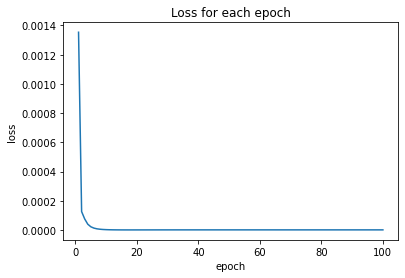

In [ ]:
lst = model.get_loss()
epoch_range = list(range(1,101))
plt.plot(epoch_range,lst)
plt.title("Loss for each epoch")
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
pmf = SVD(biased = False, n_epochs = 50)
model = pmf.fit(mat)

Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 352933.67it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 364255.73it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 377894.94it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 372971.91it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 375751.71it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 351220.40it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358701.59it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356205.06it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360918.76it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 369535.43it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 370493.42it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 374605.04it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 360422.16it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 375450.03it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 369941.61it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 372903.80it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 366876.57it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 371364.97it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 364104.65it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 371862.88it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 369973.58it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 376168.03it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378460.33it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378480.05it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 382308.21it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 371011.95it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 377951.84it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 382570.15it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 380304.67it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378713.15it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 381066.65it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 379666.07it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378248.91it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 379986.46it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 369212.67it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 376793.26it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 377116.01it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378548.39it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 381281.84it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 380977.10it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378191.48it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 379026.37it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 384202.86it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 379259.30it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 375818.02it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 380283.91it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 377285.40it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 373723.00it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 368778.70it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 381173.02it/s]


In [ ]:
u_list, f_list = test_mat.nonzero() 
y_test = test_mat[u_list.astype(int), f_list.astype(int)]
pred = model.predict(u_list.astype(int), f_list.astype(int))
pred_scaled = []
for p in pred:
    if p<1:
        pred_scaled.append(1)
    elif p>5:
        pred_scaled.append(5)
    else:
        pred_scaled.append(p)
RMSE(pred_scaled,y_test)

0.9186851

Text(0, 0.5, 'loss')

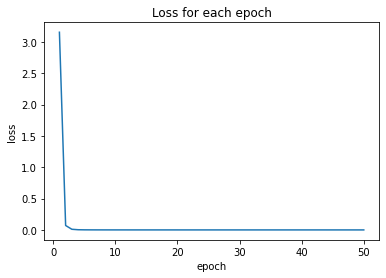

In [ ]:
lst = model.get_loss()
epoch_range = list(range(1,51))
plt.plot(epoch_range,lst)
plt.title("Loss for each epoch")
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
latent_factor_lst = [5,10,15,20,25,30]
rmse_lst = []
for lf in latent_factor_lst:
    svd = SVD(k = lf, n_epochs = 100)
    model = svd.fit(mat)
    u_list, f_list = test_mat.nonzero() 
    y_test = test_mat[u_list.astype(int), f_list.astype(int)]
    pred = model.predict(u_list.astype(int), f_list.astype(int))
    pred_scaled = []
    for p in pred:
        if p<1:
            pred_scaled.append(1)
        elif p>5:
            pred_scaled.append(5)
        else:
            pred_scaled.append(p)
    rmse = RMSE(pred_scaled,y_test)
    rmse_lst.append(rmse)

Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821126.89it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819123.68it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 813934.65it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819824.80it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 823103.49it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 815367.54it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818378.70it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821320.69it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822413.41it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 817485.30it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 816103.70it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 816108.46it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818353.15it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820876.24it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 799006.85it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 805452.42it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 804343.44it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 810841.28it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 815953.78it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 811548.69it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822090.73it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819097.38it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819879.28it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 816639.42it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819844.03it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 815367.89it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819121.55it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819842.96it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820590.43it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 816088.70it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 817119.08it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820575.81it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 814631.48it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821319.44it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 824349.60it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818595.87it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820591.68it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 811706.07it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 811729.62it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818616.64it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 817605.32it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821345.88it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822023.79it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822068.36it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822649.04it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822090.37it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820587.58it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 824323.68it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819344.45it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818334.00it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 806595.48it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820577.41it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 814139.99it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821348.74it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822821.87it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 817644.98it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818662.25it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821396.81it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819844.56it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822092.34it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 815388.67it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821126.71it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818026.92it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821197.43it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820570.81it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 824312.16it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820467.04it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 821199.22it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822822.76it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820424.43it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 824887.20it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820088.88it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819844.56it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822073.90it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820392.52it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822115.61it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820569.92it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 823568.32it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 823573.89it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 799990.96it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819106.97it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820571.71it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818103.13it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 823088.24it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819919.87it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 813908.68it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 819823.73it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822071.76it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 823831.94it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818352.44it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822069.97it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822088.94it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 820854.47it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 818336.66it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 824351.04it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822667.33it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 825337.44it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 826034.79it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 824306.59it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 822839.08it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543028.21it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542203.95it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544867.82it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 539626.61it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542929.51it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542934.20it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543069.06it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542732.92it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542282.99it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543378.25it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 541277.09it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 541955.76it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542007.41it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543934.75it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543923.46it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543063.20it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 531722.36it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543597.22it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 538510.30it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 541618.19it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543591.74it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 541421.07it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544907.69it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542928.81it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545609.53it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543582.74it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 541621.07it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545030.48it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543340.71it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546049.83it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 538951.76it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543582.82it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543861.57it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543717.77it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544025.98it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543909.91it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542719.74it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544899.04it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545754.72it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547004.69it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544250.80it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546230.50it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545798.82it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545564.35it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545568.77it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546342.27it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 539347.94it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546021.80it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546362.66it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544906.75it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544571.23it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546814.64it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544250.88it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545568.22it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 538664.19it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 542618.03it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 538883.45it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 530255.96it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 527647.24it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545899.83it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545408.86it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543592.84it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546893.53it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546085.22it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 543924.87it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545520.05it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547319.80it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546230.42it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546098.56it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544238.33it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546885.61it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544065.72it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546670.94it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546551.92it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545658.81it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544899.59it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 540675.76it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 548143.55it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547948.74it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545894.07it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 548013.63it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547218.11it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546563.00it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545782.02it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544242.72it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546555.80it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545814.28it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545568.77it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545568.53it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 539232.71it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545891.15it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547559.12it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 544935.77it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 545568.14it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546564.19it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547297.43it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 547218.43it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 546228.61it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 551668.08it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 553271.53it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438674.29it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438640.04it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438039.85it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438728.06it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436571.01it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438106.53it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440184.07it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439110.69it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439602.47it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440835.96it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440268.25it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438545.43it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440452.58it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438872.23it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 442351.41it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 441146.91it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437591.21it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438666.44it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437852.00it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439097.93it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437405.82it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436555.67it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439482.38it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437626.92it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437616.83it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438667.36it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436984.23it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438181.38it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439769.04it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438122.14it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436569.24it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436775.85it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 435124.93it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438689.27it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439034.51it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438903.30it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439551.50it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439220.32it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437621.59it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438554.29it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 433035.90it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438452.89it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439700.51it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438048.59it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438131.95it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439117.84it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439228.13it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439760.89it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437634.58it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438982.65it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439759.87it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439057.39it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438052.91it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439289.00it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439339.04it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439523.10it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439799.00it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438912.64it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438339.84it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439763.97it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437203.12it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437534.42it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438474.89it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438109.84it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438688.56it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439040.59it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437836.05it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438481.21it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440688.03it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439768.32it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438100.18it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440410.55it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438474.23it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440267.27it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437843.06it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436908.32it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437707.43it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 441100.52it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436608.72it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439980.38it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440417.95it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 436144.42it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439725.30it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438689.27it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438875.55it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440474.93it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438911.31it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438138.82it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438899.12it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438343.50it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439115.49it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439184.76it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438346.96it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438540.74it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 437121.12it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438849.23it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439403.10it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 438688.61it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 439120.19it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 440726.10it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356938.99it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356054.60it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357362.54it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356167.86it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356008.74it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356555.27it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353344.68it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355215.22it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355709.73it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356439.14it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357223.88it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356008.04it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355669.02it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356188.66it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357503.34it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355132.69it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356726.60it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356403.81it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356085.87it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354548.83it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355834.58it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355984.21it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356371.95it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355516.21it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356786.94it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 352002.13it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357378.51it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354841.72it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356360.25it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355343.06it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355623.06it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354543.77it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357419.41it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356727.07it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353013.36it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354265.50it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355697.60it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355876.27it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357734.96it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355249.44it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356799.72it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356656.81it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357281.92it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355532.51it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357571.16it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354966.12it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357403.85it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356919.15it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357803.14it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357217.36it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355951.08it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355706.08it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356751.17it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355522.37it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356073.21it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356519.68it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357225.51it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356513.79it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356645.63it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356647.82it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357034.82it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356511.36it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355581.87it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356373.74it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357188.43it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356797.06it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 354740.97it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357077.80it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358680.88it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356857.52it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356737.93it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358582.29it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 353336.88it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358548.62it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357497.48it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 355623.86it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357497.15it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358339.40it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357643.16it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358669.12it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358784.56it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358900.31it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358494.18it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356839.34it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358638.53it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357028.98it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357927.82it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358454.80it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358070.76it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358362.50it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 356840.89it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358743.34it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358343.42it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358755.68it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358206.48it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 359096.21it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357075.78it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358048.83it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 358779.62it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 357601.70it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300660.91it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300864.05it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300796.67it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300167.13it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300273.38it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299360.52it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 301143.49it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300553.95it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300596.52it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300566.82it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300163.43it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300174.53it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299800.41it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300266.24it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 295597.68it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300160.35it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 298996.93it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300268.99it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299541.16it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300501.90it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300164.50it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300813.62it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299634.35it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299264.71it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300085.59it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300303.00it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299999.61it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 298315.53it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 298769.97it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299796.84it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299148.38it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300103.74it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 298980.29it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299776.52it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 281515.93it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 282717.11it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 289256.25it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285943.98it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286786.15it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299913.91it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300519.69it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300738.72it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299842.65it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299725.52it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299967.40it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300822.13it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299759.57it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300095.77it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300334.43it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299325.73it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300777.39it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300358.73it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300355.51it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 295852.56it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299562.74it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300829.39it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300194.00it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299977.18it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 301005.66it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299348.80it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300530.77it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299050.93it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 298825.75it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299331.66it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 301047.09it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 301030.67it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299800.44it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299866.49it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300837.99it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299965.45it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299896.14it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299338.83it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299844.36it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300626.99it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 301066.08it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300442.53it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300901.17it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300560.41it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300218.73it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 300045.14it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300175.55it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300745.93it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300469.40it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300128.02it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300249.98it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299252.78it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300179.54it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300432.82it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299805.63it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299700.28it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300821.67it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300353.21it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299568.02it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 295718.77it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300844.71it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 299862.77it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300774.99it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300328.13it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300971.40it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 300063.55it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253323.91it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 251854.08it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252789.50it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253795.16it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252508.50it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 250170.28it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253648.51it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252546.86it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252598.24it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253346.52it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252744.31it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 251893.06it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253175.51it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 251892.76it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252889.49it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252189.45it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252788.07it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252882.72it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253245.00it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253558.95it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252965.40it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253343.30it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253074.70it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 251869.44it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252254.84it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252742.13it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 249968.94it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252295.24it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253407.13it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253482.24it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252859.08it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252613.79it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253164.26it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253554.16it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253272.84it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253797.86it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253990.34it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253484.25it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253003.15it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252173.04it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253755.72it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253495.98it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252885.51it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253978.34it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253553.64it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253358.02it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253769.35it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252249.85it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253004.32it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253575.38it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252985.55it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252153.03it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253796.27it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252964.23it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252436.65it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252497.39it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 251998.71it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253394.09it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253100.86it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253004.08it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 249547.84it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253801.06it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253474.96it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252850.73it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253871.20it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 254138.00it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253601.44it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253401.23it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 251112.71it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252818.63it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253643.11it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252802.24it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253810.12it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253358.02it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253569.42it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253314.07it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253908.83it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252859.67it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253394.65it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 254002.30it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252788.92it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252315.63it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252064.03it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252637.26it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253432.12it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253189.66it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252625.45it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253144.47it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253456.45it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253071.95it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252088.64it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252861.65it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253100.62it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 250058.62it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 254095.48it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253386.37it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252870.96it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252987.30it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 252861.75it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 253753.70it/s]


In [ ]:
latent_factor_lst_1 = [1,2,3,4]
rmse_lst_1 = []
for lf in latent_factor_lst_1:
    svd = SVD(k = lf, n_epochs = 100)
    model = svd.fit(mat)
    u_list, f_list = test_mat.nonzero() 
    y_test = test_mat[u_list.astype(int), f_list.astype(int)]
    pred = model.predict(u_list.astype(int), f_list.astype(int))
    pred_scaled = [1 if p<1 else 5 if p>5 else p for p in pred]
    rmse = RMSE(pred_scaled,y_test)
    rmse_lst_1.append(rmse)

Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293910.14it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289588.42it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1275057.54it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293008.85it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1288943.90it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291472.82it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289610.00it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291575.32it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1284452.89it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289597.23it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1287827.21it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289623.66it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1284101.67it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291466.20it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293875.11it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1299420.38it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1287774.94it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1284150.59it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291465.76it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297091.50it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293330.85it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1281168.37it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295227.10it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289670.35it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291535.56it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1290309.42it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289669.03it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297054.07it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289863.77it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298978.25it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293329.96it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293332.18it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297053.18it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1285962.62it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295223.55it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1290211.53it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297047.83it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1301487.51it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297037.58it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1290346.46it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295126.69it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1282182.53it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1301933.60it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298973.33it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298926.41it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1300842.70it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291523.19it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293314.46it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297103.53it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291796.27it/s]


Current epoch:  51


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295183.56it/s]


Current epoch:  52


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293100.96it/s]


Current epoch:  53


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1296964.51it/s]


Current epoch:  54


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295142.24it/s]


Current epoch:  55


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1302442.90it/s]


Current epoch:  56


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1304256.95it/s]


Current epoch:  57


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1303323.19it/s]


Current epoch:  58


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293371.16it/s]


Current epoch:  59


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1302685.11it/s]


Current epoch:  60


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289610.44it/s]


Current epoch:  61


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289620.57it/s]


Current epoch:  62


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1300850.77it/s]


Current epoch:  63


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1303461.33it/s]


Current epoch:  64


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298888.43it/s]


Current epoch:  65


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289669.03it/s]


Current epoch:  66


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298978.69it/s]


Current epoch:  67


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298970.65it/s]


Current epoch:  68


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1286058.55it/s]


Current epoch:  69


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293322.87it/s]


Current epoch:  70


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1305833.49it/s]


Current epoch:  71


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298930.88it/s]


Current epoch:  72


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297025.55it/s]


Current epoch:  73


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293317.56it/s]


Current epoch:  74


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1293376.04it/s]


Current epoch:  75


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295250.21it/s]


Current epoch:  76


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1304569.70it/s]


Current epoch:  77


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1301484.37it/s]


Current epoch:  78


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297101.30it/s]


Current epoch:  79


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1300844.50it/s]


Current epoch:  80


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298966.18it/s]


Current epoch:  81


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1291531.58it/s]


Current epoch:  82


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1289670.35it/s]


Current epoch:  83


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297103.08it/s]


Current epoch:  84


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1294755.40it/s]


Current epoch:  85


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1300844.95it/s]


Current epoch:  86


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1285987.15it/s]


Current epoch:  87


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1300851.67it/s]


Current epoch:  88


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1304618.38it/s]


Current epoch:  89


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1298973.78it/s]


Current epoch:  90


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1306425.84it/s]


Current epoch:  91


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1296474.18it/s]


Current epoch:  92


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1306465.17it/s]


Current epoch:  93


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1295236.43it/s]


Current epoch:  94


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1297100.41it/s]


Current epoch:  95


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1287774.94it/s]


Current epoch:  96


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1284106.04it/s]


Current epoch:  97


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1307144.07it/s]


Current epoch:  98


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1305362.15it/s]


Current epoch:  99


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1296990.35it/s]


Current epoch:  100


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1274638.71it/s]


Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135218.60it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1128003.10it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130841.68it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1134234.73it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1136123.82it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1136463.06it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135126.45it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130850.49it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1133718.08it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1128539.86it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135170.47it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139496.76it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130807.81it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1123786.90it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1125284.37it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1108905.41it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1116717.19it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1124774.15it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1119613.38it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1125238.09it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1128018.94it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1129319.94it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130946.35it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130953.46it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1129525.01it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130906.38it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135210.41it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132017.16it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132271.43it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135232.59it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1122354.79it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130942.96it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135132.59it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130022.63it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139429.02it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1115442.41it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1136564.66it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1128050.96it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135115.19it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1143092.90it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1137996.92it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1140805.77it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132310.82it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132795.61it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135132.59it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1137184.95it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130894.18it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1129468.58it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130820.01it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1114178.43it/s]


Current epoch:  51


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1125237.75it/s]


Current epoch:  52


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1133298.15it/s]


Current epoch:  53


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1133745.31it/s]


Current epoch:  54


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1125181.75it/s]


Current epoch:  55


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132768.08it/s]


Current epoch:  56


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135173.54it/s]


Current epoch:  57


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1136604.01it/s]


Current epoch:  58


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1140387.47it/s]


Current epoch:  59


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135168.42it/s]


Current epoch:  60


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139494.01it/s]


Current epoch:  61


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138069.30it/s]


Current epoch:  62


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132275.17it/s]


Current epoch:  63


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1143835.71it/s]


Current epoch:  64


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138170.85it/s]


Current epoch:  65


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138015.79it/s]


Current epoch:  66


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135133.27it/s]


Current epoch:  67


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1140926.77it/s]


Current epoch:  68


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132311.50it/s]


Current epoch:  69


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1136575.27it/s]


Current epoch:  70


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1144391.46it/s]


Current epoch:  71


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1140920.22it/s]


Current epoch:  72


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1065270.63it/s]


Current epoch:  73


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1105850.15it/s]


Current epoch:  74


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1128099.15it/s]


Current epoch:  75


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1121030.84it/s]


Current epoch:  76


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1126566.29it/s]


Current epoch:  77


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1145157.15it/s]


Current epoch:  78


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1140817.15it/s]


Current epoch:  79


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1126631.50it/s]


Current epoch:  80


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1137988.35it/s]


Current epoch:  81


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139433.83it/s]


Current epoch:  82


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139241.65it/s]


Current epoch:  83


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1130929.41it/s]


Current epoch:  84


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138016.48it/s]


Current epoch:  85


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1142333.08it/s]


Current epoch:  86


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1133700.38it/s]


Current epoch:  87


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139438.65it/s]


Current epoch:  88


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138980.80it/s]


Current epoch:  89


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139445.18it/s]


Current epoch:  90


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138088.51it/s]


Current epoch:  91


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1142372.48it/s]


Current epoch:  92


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1142330.31it/s]


Current epoch:  93


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1138039.11it/s]


Current epoch:  94


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1132070.79it/s]


Current epoch:  95


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1142332.73it/s]


Current epoch:  96


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139495.39it/s]


Current epoch:  97


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1135123.38it/s]


Current epoch:  98


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139439.68it/s]


Current epoch:  99


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1139546.29it/s]


Current epoch:  100


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1136198.70it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993550.59it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989222.15it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 998569.75it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995752.41it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993583.53it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992493.89it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 987086.76it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 987493.63it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994674.26it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992452.67it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989216.45it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 991356.14it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 984260.36it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995782.87it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993584.84it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 991417.31it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 998039.73it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996858.43it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995036.27it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995792.85it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993546.67it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 991357.70it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 988137.40it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993937.94it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989209.45it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994652.77it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994687.88it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992476.41it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 997355.59it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995735.60it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 988171.54it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995758.45it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 985954.92it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995089.50it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996265.03it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989132.49it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996544.54it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993240.61it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993421.71it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992785.65it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994676.62it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994683.17it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996127.82it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992163.45it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 960252.79it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 972130.65it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 984891.45it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 990302.80it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993585.36it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989992.25it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996096.29it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 990295.01it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 955615.85it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996161.46it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 999100.60it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992206.99it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994682.64it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 984882.71it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 999120.70it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 998028.65it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989810.31it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 974231.67it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 980611.74it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994685.26it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989216.19it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993379.89it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996881.60it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992455.54it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995783.40it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996888.97it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996086.04it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 988513.30it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 998731.14it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 987041.86it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 981667.01it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 981651.95it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 991813.43it/s]


Current epoch:  78


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1000209.05it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 993585.62it/s]


Current epoch:  80


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1001324.20it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989178.36it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994825.48it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 997964.54it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 999068.88it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994712.25it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992488.93it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995045.18it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 985218.61it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 995749.00it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 989181.98it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 997995.67it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 991371.75it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992881.73it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 994647.27it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 986002.30it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 997964.28it/s]


Current epoch:  97


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1000172.48it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992671.33it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 992459.45it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 996900.28it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901964.06it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896612.71it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893738.59it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899956.27it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897398.65it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897673.03it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899292.85it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895027.77it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890016.99it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895137.05it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898392.84it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898391.13it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899381.10it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 878233.34it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 891276.10it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900164.18it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 881589.57it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893927.76it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896580.56it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893044.80it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 884272.87it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898699.49it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896566.30it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899269.71it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900166.11it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899283.64it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896010.34it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898366.77it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900185.64it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 879088.88it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895711.90it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898936.57it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901063.86it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893933.48it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897473.09it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896424.74it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895454.65it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895390.09it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896606.96it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896604.19it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901998.75it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895950.38it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898026.81it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896565.66it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899239.73it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898358.64it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897541.58it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901065.37it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900143.79it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896603.34it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 904487.13it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900025.35it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901967.94it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 902872.53it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898380.23it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 903684.62it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897473.09it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898371.25it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901072.90it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898394.34it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 851419.64it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 892217.97it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893030.01it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897466.27it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 903832.81it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894411.64it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897488.67it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901058.92it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894864.22it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898717.03it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901950.70it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 904689.33it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893930.09it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901054.83it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 888106.90it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900158.81it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897494.21it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901998.53it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 900193.15it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898823.36it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899288.35it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900188.00it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 905595.27it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 884250.30it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899141.44it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897424.24it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899998.31it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 889378.40it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895579.32it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 903244.25it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 905592.01it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899287.06it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901967.07it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 905701.28it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897353.43it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901989.48it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 903773.09it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898728.37it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 905064.29it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 902880.08it/s]


Text(0, 0.5, 'RMSE')

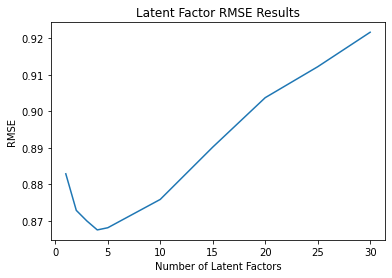

In [ ]:
rmse_lst_1+=rmse_lst
latent_factor_lst_1+=latent_factor_lst
plt.plot(latent_factor_lst_1, rmse_lst_1)
plt.title("Latent Factor RMSE Results")
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')

In [ ]:
svd = SVD(k = 4, n_epochs = 100)
model = svd.fit(mat)
u_list, f_list = test_mat.nonzero() 
y_test = test_mat[u_list.astype(int), f_list.astype(int)]
pred = model.predict(u_list.astype(int), f_list.astype(int))
pred_scaled = [1 if p<1 else 5 if p>5 else p for p in pred]
RMSE(pred_scaled,y_test)

Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898858.88it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 902355.73it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901093.11it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898352.66it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897473.09it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 891275.26it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899606.54it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901090.31it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898370.19it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895685.76it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900157.52it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896448.58it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898377.67it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897500.19it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 900162.89it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 881131.81it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 892551.22it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895710.41it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897477.79it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898358.86it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899927.95it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901411.93it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898691.36it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 885170.32it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 902874.90it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898427.69it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895611.83it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898390.92it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901066.44it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890394.58it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899118.74it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898389.64it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 899287.06it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898367.62it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 885141.89it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 866700.73it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896592.27it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890393.74it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890392.48it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894000.57it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895125.81it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896573.96it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894783.63it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897499.33it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896049.04it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 889345.30it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896603.56it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893047.12it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894819.47it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896306.42it/s]


Current epoch:  51


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894820.32it/s]


Current epoch:  52


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 887750.45it/s]


Current epoch:  53


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898366.55it/s]


Current epoch:  54


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890395.84it/s]


Current epoch:  55


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890811.79it/s]


Current epoch:  56


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 889520.89it/s]


Current epoch:  57


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893898.77it/s]


Current epoch:  58


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 891242.86it/s]


Current epoch:  59


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 891416.45it/s]


Current epoch:  60


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893597.93it/s]


Current epoch:  61


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896611.43it/s]


Current epoch:  62


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898396.26it/s]


Current epoch:  63


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 883406.39it/s]


Current epoch:  64


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 890662.38it/s]


Current epoch:  65


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 888609.16it/s]


Current epoch:  66


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895687.46it/s]


Current epoch:  67


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893932.63it/s]


Current epoch:  68


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 876523.38it/s]


Current epoch:  69


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 858212.50it/s]


Current epoch:  70


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 885060.35it/s]


Current epoch:  71


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895680.45it/s]


Current epoch:  72


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 887758.80it/s]


Current epoch:  73


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 891550.11it/s]


Current epoch:  74


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894693.73it/s]


Current epoch:  75


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 892948.49it/s]


Current epoch:  76


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 892158.52it/s]


Current epoch:  77


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897242.76it/s]


Current epoch:  78


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 887731.66it/s]


Current epoch:  79


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894911.73it/s]


Current epoch:  80


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895687.04it/s]


Current epoch:  81


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 886013.86it/s]


Current epoch:  82


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895686.83it/s]


Current epoch:  83


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895475.03it/s]


Current epoch:  84


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 900217.83it/s]


Current epoch:  85


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893038.04it/s]


Current epoch:  86


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 876521.54it/s]


Current epoch:  87


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895683.85it/s]


Current epoch:  88


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 898979.80it/s]


Current epoch:  89


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 900475.68it/s]


Current epoch:  90


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 897497.20it/s]


Current epoch:  91


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 878236.20it/s]


Current epoch:  92


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 894820.53it/s]


Current epoch:  93


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893394.52it/s]


Current epoch:  94


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 893910.20it/s]


Current epoch:  95


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 896582.48it/s]


Current epoch:  96


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895688.31it/s]


Current epoch:  97


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 889529.90it/s]


Current epoch:  98


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895855.99it/s]


Current epoch:  99


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 895679.82it/s]


Current epoch:  100


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 901059.99it/s]


0.8674958

In [ ]:
RMSE(pred_scaled,y_test)

0.8674958

In [ ]:
latent_factor_lst = [1,2,3,4,5,10,15,20,25,30]
rmse_lst = []
for lf in latent_factor_lst:
    svd = SVD(k = lf, biased = False, n_epochs = 50)
    model = svd.fit(mat)
    u_list, f_list = test_mat.nonzero() 
    y_test = test_mat[u_list.astype(int), f_list.astype(int)]
    pred = model.predict(u_list.astype(int), f_list.astype(int))
    pred_scaled = [1 if p<1 else 5 if p>5 else p for p in pred]
    rmse = RMSE(pred_scaled,y_test)
    rmse_lst.append(rmse)

Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2340519.04it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2358664.04it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2337946.56it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2374961.87it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2344068.92it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2350359.48it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2375151.61it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2350204.40it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2362717.12it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2344284.32it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368836.30it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2356286.80it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2347215.09it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2381448.10it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2350129.80it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2367662.79it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2364138.85it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368931.43it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2374887.18it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2350185.39it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2356500.04it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368707.01it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2344218.82it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2356788.34it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2358392.96it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2360622.43it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2345870.49it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2369014.66it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368701.07it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368956.69it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2365033.29it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2356520.63it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2362535.28it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2356554.46it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2375020.13it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368753.08it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2364282.45it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368172.16it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2349243.66it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368536.13it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2361053.47it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2375020.13it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2362489.45it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2350415.08it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2362723.04it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368782.80it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2362504.23it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368989.39it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2374262.93it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 2368026.60it/s]


Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1855947.74it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1871453.04it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1879315.88it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887189.42it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1863749.56it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1875254.67it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883251.94it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1897219.46it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1882859.37it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1867000.94it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1875102.87it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1886949.86it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1847087.09it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1879141.91it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1867611.37it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887228.10it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1878308.04it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1879288.76it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1859895.44it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887192.25it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883238.79it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883142.98it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1871491.08it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1867606.75it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1879212.06it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883131.71it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1868474.60it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883214.36it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887194.14it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887356.39it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887093.21it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887194.14it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883258.51it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1871505.92it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887189.42it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1891125.41it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1884392.05it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887193.19it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1899143.31it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883384.39it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887359.22it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1859773.59it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1887188.48it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1871368.63it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1880505.56it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1868916.69it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1879313.08it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1879312.14it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1883214.36it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1871510.56it/s]


Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562616.89it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1584771.95it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1560030.45it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1581908.21it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1561461.42it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1572984.79it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1574068.79it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1570878.78it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1570910.15it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1568269.49it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554725.01it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554831.29it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1571160.52it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1576541.39it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1581962.56it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1568178.30it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1567971.86it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554393.46it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1576601.96it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1565393.63it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1565578.62it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554707.09it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1568530.75it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1575117.48it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1564540.64it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1576450.55it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1570810.16it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1581937.37it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1573448.89it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1584497.95it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1582183.97it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1568898.35it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1573559.06it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1573667.93it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1565497.48it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1584807.87it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1584626.96it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1579192.17it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1544938.84it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1575847.20it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562832.28it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1571094.49it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1576619.07it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1576628.95it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1573841.11it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1576508.48it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1584836.48it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1582197.23it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1566725.89it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1587639.41it/s]


Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1349251.64it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1345643.17it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1344367.24it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1353727.40it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1349538.10it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1335591.40it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1339512.39it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1342697.78it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1351578.22it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1350319.99it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1358430.37it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1331575.89it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1314156.90it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1347666.23it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1341648.13it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1343416.79it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1337659.19it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1346473.85it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1347868.29it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1335653.77it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1333546.47it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1345639.81it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1353595.88it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1360759.80it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1352739.43it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1278611.19it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1351494.52it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1353599.27it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1343564.50it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1331560.86it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1350227.27it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1359737.06it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1353414.41it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1355758.78it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1351690.47it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1353661.88it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1349606.60it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1343367.55it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1355774.36it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1354116.77it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1357814.35it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1361396.67it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1357702.53it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1341493.68it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1349808.28it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1356261.86it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1343414.40it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1351631.92it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1349446.94it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1355692.58it/s]


Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1193718.42it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1195408.96it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1178492.75it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1191276.32it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1200145.37it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1190588.50it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1186069.76it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1197110.36it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1191405.25it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192224.63it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1178270.61it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1185929.69it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1184209.01it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1178572.94it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1171975.89it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1191624.84it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1182908.61it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1178151.12it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1178188.25it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1179742.15it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1182955.31it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192759.07it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1181990.60it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1184400.32it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1184222.75it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1190677.86it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192222.74it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192739.10it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1197262.20it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1189529.23it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1195419.55it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1181300.90it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1195592.92it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1194920.16it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1191319.17it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1194641.52it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1195345.37it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1187265.48it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1196032.63it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1193884.88it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1185285.98it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1196424.14it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1197010.54it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192234.41it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192351.51it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1193892.43it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1186596.09it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1167558.07it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1190667.35it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1192362.05it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 730066.33it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 715450.40it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 724587.30it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 717484.58it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 720687.87it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725261.10it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 712217.88it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725300.80it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 722460.18it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725246.47it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 724817.65it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 712114.31it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 712756.08it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 703459.13it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 717615.08it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 721305.92it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 721307.99it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 717294.02it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 718019.98it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 709927.77it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 727557.14it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 721082.62it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 723617.72it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 721323.70it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 719942.64it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 686628.34it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 721283.87it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 721089.92it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 727306.41it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 730113.90it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 720541.53it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725890.65it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 726985.44it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 728877.39it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 726448.04it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 724184.82it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725586.68it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725321.56it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725781.81it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 726865.78it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 728040.86it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 724345.84it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 722873.34it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 712881.78it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 723218.53it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 727312.85it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725354.73it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 725975.93it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 719396.41it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 728020.51it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 502575.01it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 503664.32it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 501931.08it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 509830.25it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 508085.57it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 504233.43it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510426.16it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 507824.87it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 509166.51it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 507371.81it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 500382.16it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510513.81it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 505010.04it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 513002.52it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 512001.88it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 506961.08it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 509660.75it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 509429.28it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 506249.53it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 505985.00it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510083.65it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 506986.14it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510317.50it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 503645.77it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 513122.44it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 513781.65it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 511274.80it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 508546.00it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 508594.84it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 508982.28it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 512334.04it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 507524.79it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 512343.99it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 511725.70it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510276.81it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 512481.61it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510110.18it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510998.50it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 505328.59it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 512635.45it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 504794.66it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 514094.14it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 511336.22it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510375.66it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 508295.49it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 494544.09it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 497345.91it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 509137.81it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 510562.76it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:01<00:00, 509502.63it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 390858.25it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397217.06it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 385671.41it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393944.41it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393900.19it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 392345.19it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394294.97it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 391437.71it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393260.08it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394554.80it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 392018.61it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393213.76it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 391349.79it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 390180.96it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 395445.12it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393789.92it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 392748.45it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393714.37it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 395044.03it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 396847.28it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393179.90it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 389344.31it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394575.54it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393965.29it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 395805.07it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 391868.55it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394339.15it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 395297.89it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397090.06it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393701.31it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 389349.65it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 398641.77it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393834.53it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 392855.24it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397486.99it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394469.71it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397308.55it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 396977.79it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394652.21it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 396530.69it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 392949.60it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 395457.25it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 392828.95it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397794.96it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 394186.70it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 393955.10it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 378984.30it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 390511.31it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397306.17it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 397824.89it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339124.55it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339733.58it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339284.78it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339242.34it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338404.55it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337555.49it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337371.89it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 332566.95it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337525.47it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 332322.24it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337308.60it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338994.47it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 334635.79it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 332161.53it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 332994.82it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339811.61it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 334058.94it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337010.29it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337354.53it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340187.53it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339108.10it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337624.58it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339304.38it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338244.78it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338732.53it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338345.66it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338095.95it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337945.79it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337153.72it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 336738.67it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340719.57it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338125.10it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337612.57it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338073.54it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338744.35it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339462.22it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340120.79it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 341025.01it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340755.24it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 339701.24it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 331499.02it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340589.01it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340689.04it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337251.17it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 337702.89it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340466.80it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 340470.52it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 342001.97it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 338845.64it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:02<00:00, 336090.17it/s]


Current epoch:  1


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286497.33it/s]


Current epoch:  2


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 287580.43it/s]


Current epoch:  3


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 281539.74it/s]


Current epoch:  4


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 284245.36it/s]


Current epoch:  5


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285393.87it/s]


Current epoch:  6


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286818.87it/s]


Current epoch:  7


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285123.07it/s]


Current epoch:  8


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286399.61it/s]


Current epoch:  9


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286131.62it/s]


Current epoch:  10


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286598.04it/s]


Current epoch:  11


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 287539.19it/s]


Current epoch:  12


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 283152.79it/s]


Current epoch:  13


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288117.29it/s]


Current epoch:  14


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286154.50it/s]


Current epoch:  15


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285130.43it/s]


Current epoch:  16


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285309.29it/s]


Current epoch:  17


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286621.11it/s]


Current epoch:  18


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286229.17it/s]


Current epoch:  19


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 284160.33it/s]


Current epoch:  20


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 287007.16it/s]


Current epoch:  21


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286165.48it/s]


Current epoch:  22


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 283193.48it/s]


Current epoch:  23


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285931.29it/s]


Current epoch:  24


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288319.15it/s]


Current epoch:  25


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286627.31it/s]


Current epoch:  26


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 287216.12it/s]


Current epoch:  27


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 284575.27it/s]


Current epoch:  28


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288717.37it/s]


Current epoch:  29


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 280480.60it/s]


Current epoch:  30


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288533.43it/s]


Current epoch:  31


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288178.07it/s]


Current epoch:  32


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 289194.26it/s]


Current epoch:  33


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286373.19it/s]


Current epoch:  34


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286159.01it/s]


Current epoch:  35


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286736.14it/s]


Current epoch:  36


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288729.53it/s]


Current epoch:  37


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286322.37it/s]


Current epoch:  38


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286137.72it/s]


Current epoch:  39


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 287355.67it/s]


Current epoch:  40


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288513.63it/s]


Current epoch:  41


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286115.25it/s]


Current epoch:  42


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288492.48it/s]


Current epoch:  43


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288883.29it/s]


Current epoch:  44


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 288808.60it/s]


Current epoch:  45


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286156.84it/s]


Current epoch:  46


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 289529.61it/s]


Current epoch:  47


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 287284.44it/s]


Current epoch:  48


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286171.90it/s]


Current epoch:  49


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 285896.48it/s]


Current epoch:  50


100%|██████████████████████████████████████████████████████████████████████| 900188/900188 [00:03<00:00, 286421.53it/s]


Text(0, 0.5, 'RMSE')

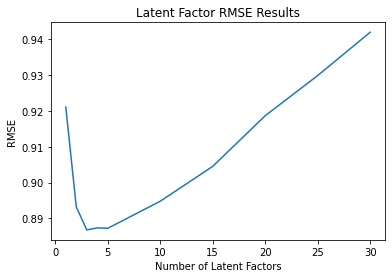

In [ ]:
plt.plot(latent_factor_lst, rmse_lst)
plt.title("Latent Factor RMSE Results")
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')

In [ ]:
svd = SVD(k = 3, biased = False, n_epochs = 50)
model = svd.fit(mat)
u_list, f_list = test_mat.nonzero() 
y_test = test_mat[u_list.astype(int), f_list.astype(int)]
pred = model.predict(u_list.astype(int), f_list.astype(int))
pred_scaled = [1 if p<1 else 5 if p>5 else p for p in pred]
RMSE(pred_scaled,y_test)

Current epoch:  1


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1553019.48it/s]


Current epoch:  2


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1543805.57it/s]


Current epoch:  3


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1530134.57it/s]


Current epoch:  4


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1546631.73it/s]


Current epoch:  5


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1533360.95it/s]


Current epoch:  6


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1544091.57it/s]


Current epoch:  7


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1523272.99it/s]


Current epoch:  8


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1538922.04it/s]


Current epoch:  9


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1485574.60it/s]


Current epoch:  10


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1530849.26it/s]


Current epoch:  11


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1550062.39it/s]


Current epoch:  12


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1532825.59it/s]


Current epoch:  13


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1538790.33it/s]


Current epoch:  14


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554723.09it/s]


Current epoch:  15


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1560115.54it/s]


Current epoch:  16


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1561695.87it/s]


Current epoch:  17


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1553475.07it/s]


Current epoch:  18


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1541525.76it/s]


Current epoch:  19


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1541317.47it/s]


Current epoch:  20


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1551421.58it/s]


Current epoch:  21


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554716.69it/s]


Current epoch:  22


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554734.61it/s]


Current epoch:  23


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562726.84it/s]


Current epoch:  24


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1560030.45it/s]


Current epoch:  25


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1557689.65it/s]


Current epoch:  26


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1559981.46it/s]


Current epoch:  27


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562748.19it/s]


Current epoch:  28


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1560025.29it/s]


Current epoch:  29


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1563478.79it/s]


Current epoch:  30


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1557597.76it/s]


Current epoch:  31


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1559965.99it/s]


Current epoch:  32


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1551039.83it/s]


Current epoch:  33


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562186.95it/s]


Current epoch:  34


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554739.74it/s]


Current epoch:  35


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1530946.72it/s]


Current epoch:  36


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1528270.32it/s]


Current epoch:  37


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562937.73it/s]


Current epoch:  38


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1560223.84it/s]


Current epoch:  39


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1544175.56it/s]


Current epoch:  40


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1559760.42it/s]


Current epoch:  41


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1566271.59it/s]


Current epoch:  42


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1568411.51it/s]


Current epoch:  43


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1565635.10it/s]


Current epoch:  44


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1560792.06it/s]


Current epoch:  45


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1562863.33it/s]


Current epoch:  46


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1566080.59it/s]


Current epoch:  47


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1570900.35it/s]


Current epoch:  48


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1549475.89it/s]


Current epoch:  49


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1546820.55it/s]


Current epoch:  50


100%|█████████████████████████████████████████████████████████████████████| 900188/900188 [00:00<00:00, 1554534.26it/s]


0.88680756

In [ ]:
RMSE(pred_scaled,y_test)

0.88680756